# Install and Import

In [1]:
!pip install -q git+https://github.com/huggingface/datasets
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q accelerate
!pip install -q evaluate
!pip install -q soundfile
!pip install -q librosa
!pip install -q tqdm
!pip install -q Albumentations

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tokenizers 0.14.1 requires huggingface_hub<0.18,>=0.16.4, but you have huggingface-hub 0.19.4 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import torch
import IPython.display as ipd
import os 
import glob
import librosa
import matplotlib.pyplot as plt
import albumentations as A

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Loading

In [3]:
data_path = "/kaggle/input/gunshot-audio-dataset"
file_path = glob.glob(data_path + "/*/*.wav", recursive = True)
# print(file_path)

df = pd.DataFrame()
df["file_path"] = file_path
df["gun_type"] = df["file_path"].str.split("/").str[-2]

df["label"] = df["file_path"].str.split("/").str[-1].str.split().str[0]
df["label"] = df["label"].astype(int) - 1
df["name"] = df["file_path"].str.split("/").str[-1]
df.head()

,file_path,gun_type,label,name
0,/kaggle/input/gunshot-audio-dataset/MG-42/7 (6...,MG-42,6,7 (66).wav
1,/kaggle/input/gunshot-audio-dataset/MG-42/7 (8...,MG-42,6,7 (89).wav
2,/kaggle/input/gunshot-audio-dataset/MG-42/7 (5...,MG-42,6,7 (50).wav
3,/kaggle/input/gunshot-audio-dataset/MG-42/7 (1...,MG-42,6,7 (10).wav
4,/kaggle/input/gunshot-audio-dataset/MG-42/7 (2...,MG-42,6,7 (21).wav


In [4]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state = 0, shuffle = True)
X = df.drop('label', axis = 1)
y = df.label

df["fold"] = 0

for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
#     print(test_idx)
    df.loc[test_idx,"fold"] = i
    
print(df)

                                             file_path gun_type  label  \
0    /kaggle/input/gunshot-audio-dataset/MG-42/7 (6...    MG-42      6   
1    /kaggle/input/gunshot-audio-dataset/MG-42/7 (8...    MG-42      6   
2    /kaggle/input/gunshot-audio-dataset/MG-42/7 (5...    MG-42      6   
3    /kaggle/input/gunshot-audio-dataset/MG-42/7 (1...    MG-42      6   
4    /kaggle/input/gunshot-audio-dataset/MG-42/7 (2...    MG-42      6   
..                                                 ...      ...    ...   
846  /kaggle/input/gunshot-audio-dataset/AK-12/3 (8...    AK-12      2   
847  /kaggle/input/gunshot-audio-dataset/AK-12/3 (5...    AK-12      2   
848  /kaggle/input/gunshot-audio-dataset/AK-12/3 (4...    AK-12      2   
849  /kaggle/input/gunshot-audio-dataset/AK-12/3 (5...    AK-12      2   
850  /kaggle/input/gunshot-audio-dataset/AK-12/3 (2...    AK-12      2   

           name  fold  
0    7 (66).wav     1  
1    7 (89).wav     4  
2    7 (50).wav     0  
3    7 (10).wav

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


# EDA

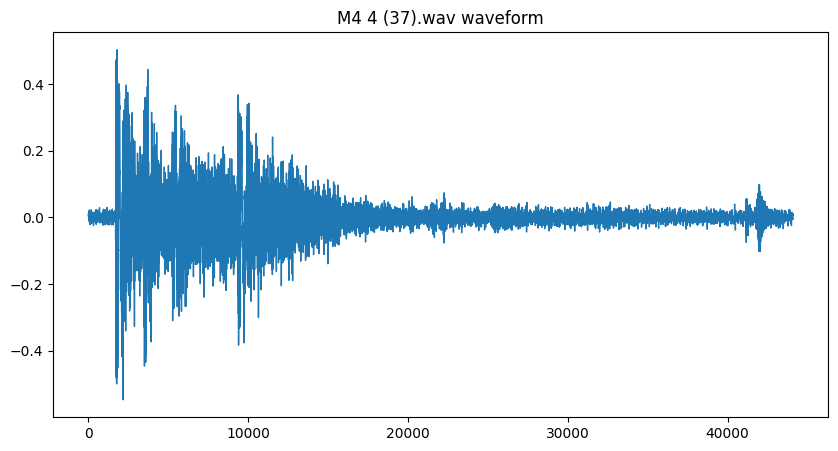

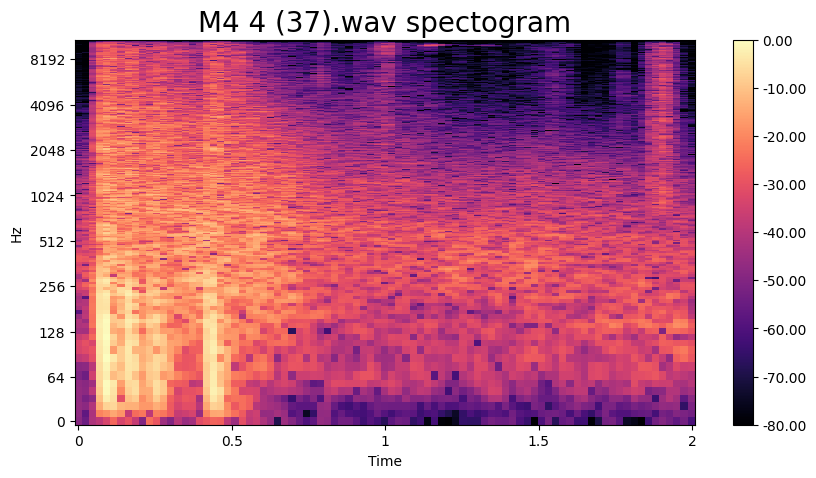

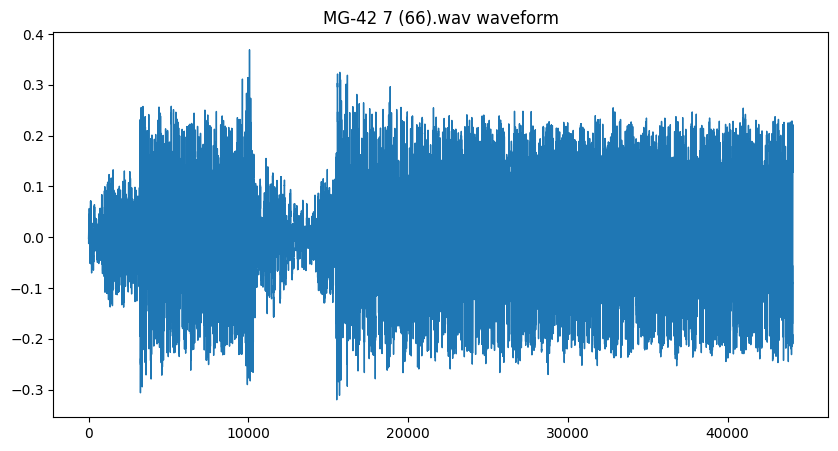

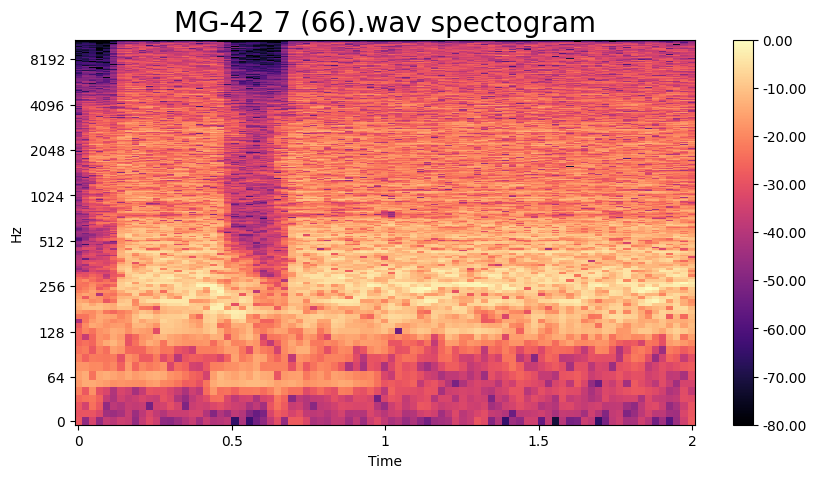

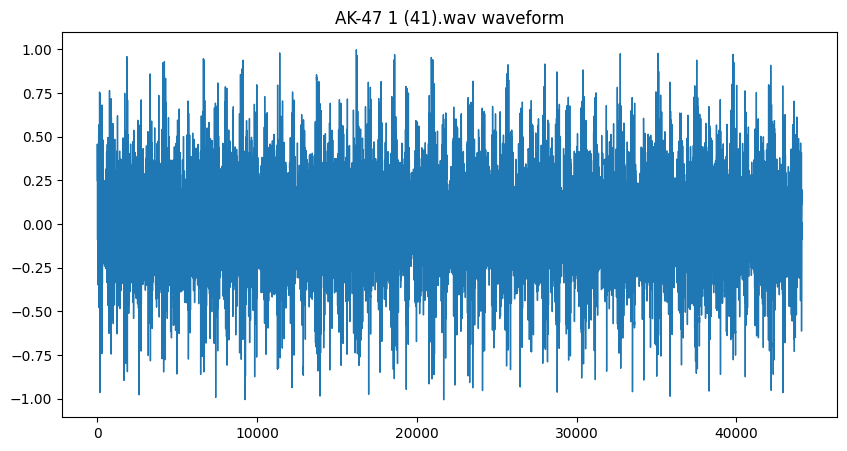

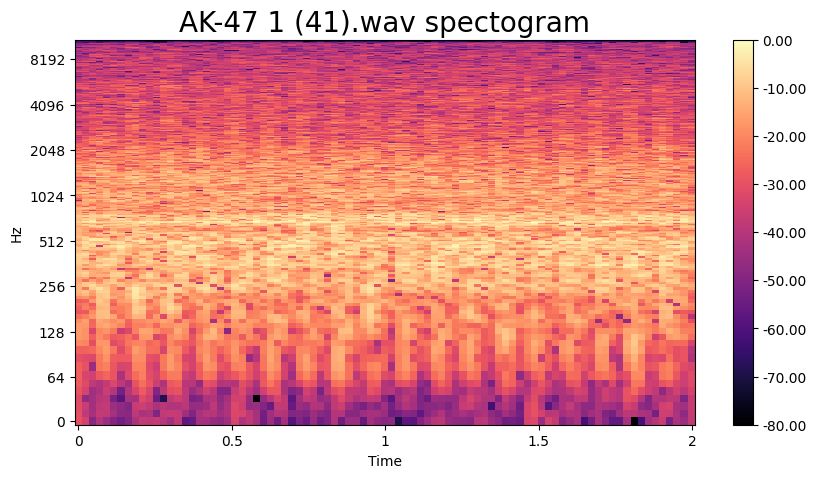

In [5]:
examples = df.sample(3).reset_index()
for i in range(3):
    file_path = examples.loc[i, "file_path"]
    ipd.display(ipd.Audio(file_path))
    y, sr = librosa.load(file_path)
    pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title=f'{examples.loc[i, "gun_type"]} {examples.loc[i, "name"]} waveform',
                 )
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(S_db,
                                  x_axis='time',
                                  y_axis='log',
                                  ax=ax)
    ax.set_title(f'{examples.loc[i, "gun_type"]} {examples.loc[i, "name"]} spectogram', fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

# Make 🤗 Dataset

In [6]:
from datasets import Dataset, Audio

dataset = Dataset.from_dict(df.to_dict('list'))

dataset = dataset.cast_column("file_path", Audio()).rename_column("file_path", "audio")
print(dataset["audio"][0])

{'path': '/kaggle/input/gunshot-audio-dataset/MG-42/7 (66).wav', 'array': array([-4.25720215e-03, -2.13623047e-04,  4.34875488e-03, ...,
        1.68579102e-01,  1.85043335e-01,  2.31369019e-01]), 'sampling_rate': 48000}


# Define Model and Feature Extractor

In [7]:
from transformers import AutoFeatureExtractor

model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True
)

preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [8]:
feature_extractor

ASTFeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "ASTFeatureExtractor",
  "feature_size": 1,
  "max_length": 1024,
  "mean": -4.2677393,
  "num_mel_bins": 128,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000,
  "std": 4.5689974
}

# Extract Features

In [9]:
sampling_rate = feature_extractor.sampling_rate
sampling_rate

16000

In [10]:
from datasets import Audio

dataset = dataset.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [11]:
dataset[0]

{'audio': {'path': '/kaggle/input/gunshot-audio-dataset/MG-42/7 (66).wav',
  'array': array([-0.00170421,  0.00764513,  0.00960774, ...,  0.17318335,
          0.19144741,  0.1937356 ]),
  'sampling_rate': 16000},
 'gun_type': 'MG-42',
 'label': 6,
 'name': '7 (66).wav',
 'fold': 1}

In [12]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        return_attention_mask=True,
    )
    return inputs

In [13]:
encoded_dataset = dataset.map(preprocess_function, remove_columns = ['audio', 'gun_type', 'name'], batched=True)

Map:   0%|          | 0/851 [00:00<?, ? examples/s]

In [14]:
encoded_dataset

Dataset({
    features: ['label', 'fold', 'input_values'],
    num_rows: 851
})

In [15]:
from transformers import AutoModelForAudioClassification


model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=9,
    ignore_mismatched_sizes = True
)

config.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([9]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([9, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [18]:
train_dataset = encoded_dataset.filter(lambda x : x['fold'] != 4).remove_columns("fold")
test_dataset = encoded_dataset.filter(lambda x : x['fold'] == 4).remove_columns("fold")


Filter:   0%|          | 0/851 [00:00<?, ? examples/s]

Filter:   0%|          | 0/851 [00:00<?, ? examples/s]

In [19]:
print(len(train_dataset))
print(len(test_dataset))

681
170


In [20]:
mean_value = np.mean(train_dataset['input_values'])

In [21]:


def transforms(examples):
    transform = A.Cutout(fill_value = mean_value)
    examples["input_values"] = [transform(image = np.array(image))['image'] for image in examples["input_values"]]
    return examples

train_dataset.set_transform(transforms)

In [22]:
from transformers import TrainingArguments

model_name = model_id.split("/")[-1]
batch_size = 2
gradient_accumulation_steps = 1
num_train_epochs = 10

training_args = TrainingArguments(
    f"{model_name}-finetuned-gunshot",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=True,
    report_to=None,
)

In [23]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.060900,1.346538,0.658824
2,2.569300,1.342743,0.688235
3,0.352100,0.722578,0.764706
4,0.489700,0.309074,0.847059
5,0.221100,0.549543,0.823529
6,0.177500,0.373237,0.823529
7,0.122700,0.393626,0.788235
8,0.066100,0.874413,0.741176
9,0.158400,0.789134,0.764706
10,0.070700,0.879463,0.752941


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has bee

TrainOutput(global_step=3410, training_loss=0.4722729159065705, metrics={'train_runtime': 2327.8862, 'train_samples_per_second': 2.925, 'train_steps_per_second': 1.465, 'total_flos': 4.616299688833843e+17, 'train_loss': 0.4722729159065705, 'epoch': 10.0})

In [24]:
trainer.push_to_hub()

'https://huggingface.co/IHHI/ast-finetuned-audioset-10-10-0.4593-finetuned-gunshot/tree/main/'